In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay, RocCurveDisplay)

In [8]:
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")

In [9]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

In [10]:
n_runs = 20

In [11]:
# Pipeline
pipeline_dt = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Espaço de busca (note o prefixo "dt__" pois nosso estimador chama-se "dt" no Pipeline)
param_dist_dt = {
    'dt__criterion': ['gini', 'entropy', 'log_loss'],  
    'dt__max_depth': range(1, 100),                    
    'dt__min_samples_split': range(2, 11),             
    'dt__min_samples_leaf': range(1, 11)               
}

# Validação cruzada estratificada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [12]:
best_scores_dt = []         # F1 no conjunto de teste de cada rodada
best_params_dt = []         # Hiperparâmetros ótimos de cada rodada
cv_results_history_dt = []  # Histórico do cv_results_ (média, desvio, etc.)

for i in range(n_runs):
    print(f"\nRodada {i+1}/{n_runs}")
    
    search_dt = RandomizedSearchCV(
        estimator=pipeline_dt,
        param_distributions=param_dist_dt,
        n_iter=5,                  # 20 iterações
        scoring='f1_macro',         # Métrica principal
        cv=cv,
        random_state=42 + i,        # Varia para cada rodada
        n_jobs=-1,
        verbose=1
    )
    
    search_dt.fit(X_train, y_train)
    
    # Armazenando resultados da validação cruzada
    cv_results = pd.DataFrame(search_dt.cv_results_)
    cv_results_history_dt.append(cv_results)
    
    # Avaliação no conjunto de teste
    best_model_dt = search_dt.best_estimator_
    y_pred_test = best_model_dt.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    best_scores_dt.append(f1_test)
    best_params_dt.append(search_dt.best_params_)
    
    print("Melhores hiperparâmetros (validação cruzada):", search_dt.best_params_)
    print("Melhor F1 (validação cruzada – média):", search_dt.best_score_)
    print("F1 no Teste:", f1_test)



Rodada 1/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'dt__min_samples_split': 4, 'dt__min_samples_leaf': 8, 'dt__max_depth': 42, 'dt__criterion': 'log_loss'}
Melhor F1 (validação cruzada – média): 0.9403935647632675
F1 no Teste: 0.9358489034244558

Rodada 2/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'dt__min_samples_split': 5, 'dt__min_samples_leaf': 8, 'dt__max_depth': 22, 'dt__criterion': 'log_loss'}
Melhor F1 (validação cruzada – média): 0.9403433351852322
F1 no Teste: 0.9352931092889707

Rodada 3/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'dt__min_samples_split': 8, 'dt__min_samples_leaf': 2, 'dt__max_depth': 29, 'dt__criterion': 'log_loss'}
Melhor F1 (validação cruzada – média): 0.9390618203257552
F1 no Teste: 0.9374405679451474

Rodada 4/20
Fitting 5 folds for each of 5 candidates, 

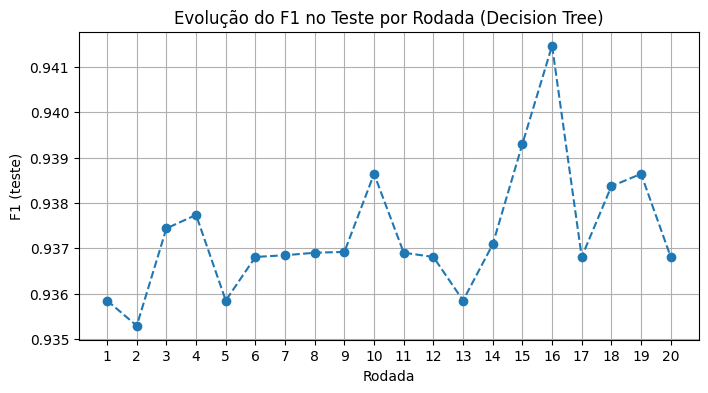

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_runs+1), best_scores_dt, marker='o', linestyle='--')
plt.title('Evolução do F1 no Teste por Rodada (Decision Tree)')
plt.xlabel('Rodada')
plt.ylabel('F1 (teste)')
plt.xticks(range(1, n_runs+1))
plt.grid(True)
plt.show()


In [14]:
best_run_index = np.argmax(best_scores_dt)
print(f"Melhor rodada: {best_run_index + 1}")
print(f"F1 nessa rodada: {best_scores_dt[best_run_index]}")
print("Melhores hiperparâmetros:", best_params_dt[best_run_index])


Melhor rodada: 16
F1 nessa rodada: 0.9414704643643181
Melhores hiperparâmetros: {'dt__min_samples_split': 4, 'dt__min_samples_leaf': 3, 'dt__max_depth': 35, 'dt__criterion': 'entropy'}


In [15]:
melhores_parametros = best_params_dt[best_run_index]

# Construindo um novo Pipeline com a melhor configuração
best_dt_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(
        criterion=melhores_parametros['dt__criterion'],
        max_depth=melhores_parametros['dt__max_depth'],
        min_samples_split=melhores_parametros['dt__min_samples_split'],
        min_samples_leaf=melhores_parametros['dt__min_samples_leaf'],
        random_state=42
    ))
])

best_dt_pipeline.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('dt',
                 DecisionTreeClassifier(criterion='entropy', max_depth=35,
                                        min_samples_leaf=3, min_samples_split=4,
                                        random_state=42))])

Desempenho no Conjunto de Teste:
Acurácia : 0.9521
Precisão : 0.9405
Recall   : 0.9424
F1-score : 0.9415
AUC      : 0.9535


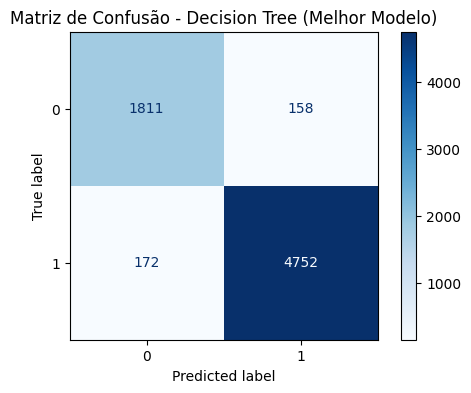

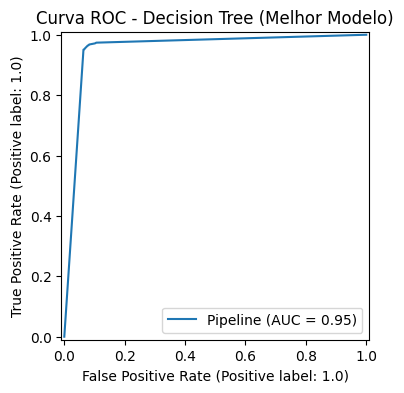


Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.91      0.92      0.92      1969
         1.0       0.97      0.97      0.97      4924

    accuracy                           0.95      6893
   macro avg       0.94      0.94      0.94      6893
weighted avg       0.95      0.95      0.95      6893



In [18]:
y_pred = best_dt_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Desempenho no Conjunto de Teste:")
print(f"Acurácia : {acc:.4f}")
print(f"Precisão : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Para problema binário, podemos calcular AUC
try:
    y_proba = best_dt_pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC      : {auc:.4f}")
except ValueError:
    print("Não foi possível calcular AUC (provavelmente é problema multiclasse).")

# Matriz de confusão (caso queira exibir rótulos específicos, use 'labels=[-1, 1]' e 'display_labels=[-1, 1]')
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusão - Decision Tree (Melhor Modelo)")
plt.show()

# Curva ROC (somente para binário)
try:
    fig_roc, ax_roc = plt.subplots(figsize=(6, 4))
    RocCurveDisplay.from_estimator(best_dt_pipeline, X_test, y_test, ax=ax_roc)
    plt.title("Curva ROC - Decision Tree (Melhor Modelo)")
    plt.show()
except ValueError:
    print("Não foi possível gerar a Curva ROC (possivelmente é multiclasse).")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
